## Implementation of Cerebral LSTM in Pytorch

#### Research Paper Title: Cerebral LSTM: A Better Alternative for Single-and Multi-Stacked LSTM Cell-Based RNNs

##### Author: [Ravin Kumar](https://mr-ravin.github.io)
##### Published Research: [https://doi.org/10.1007/s42979-020-0101-1](https://doi.org/10.1007/s42979-020-0101-1)
##### PDF available on Research Gate: [Click here to Visit](https://www.researchgate.net/publication/340013877_Cerebral_LSTM_A_Better_Alternative_for_Single-_and_Multi-Stacked_LSTM_Cell-Based_RNNs)

##### Cite Paper as: 
```Kumar, R. Cerebral LSTM: A Better Alternative for Single- and Multi-Stacked LSTM Cell-Based RNNs. SN COMPUT. SCI. 1, 85 (2020). https://doi.org/10.1007/s42979-020-0101-1```

##### Git Repo: [https://github.com/mr-ravin/cerebral-rnn-experimental-results](https://github.com/mr-ravin/cerebral-rnn-experimental-results)

In [387]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter as Parameter
from torch.optim.lr_scheduler import StepLR
from nltk.corpus import stopwords
from collections import Counter
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sparrow/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Important: 
Cerebral LSTM contains larger number of trainable parameters when compared to a Simple LSTM. So, if one wants to train Cerebral LSTM on smaller dataset, it will overfit. To avoid overfitting on smaller dataset, one can use lower values of hidden dimension.

In [411]:
Select_Model = "ALL" # Cerebral_LSTM, LSTM, BOTH, ALL

In [412]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [390]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [439]:
root_path = "/Users/sparrow/Desktop/" #'/content/drive/MyDrive/'
base_csv = root_path+'Cerebral_LSTM/IMDB Dataset.csv'
df = pd.read_csv(base_csv)
df.head()
df = df [:5000] # For demo purpose, only using 1K sample, comment this line to use complete dataset.

### Splitting to train and test data

In [392]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (3750,)
shape of test data is (1250,)


### Analysing sentiment

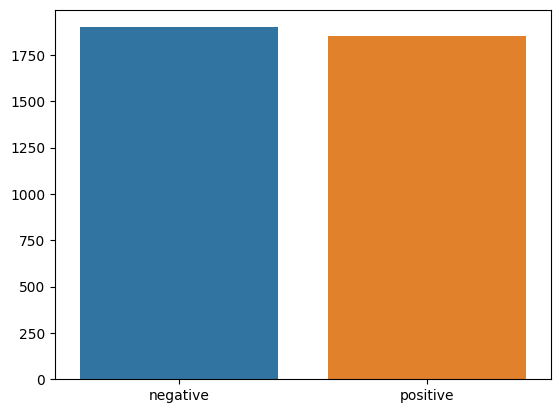

In [393]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

### Tockenization

In [394]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])

    encoded_train = [1 if label =='positive' else 0 for label in y_train]
    encoded_test = [1 if label =='positive' else 0 for label in y_val]
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [395]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

/var/folders/55/8qk_hsb17hb0d7ddn1hn87k40000gn/T/ipykernel_59855/2555102333.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [396]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


### Analysing review length

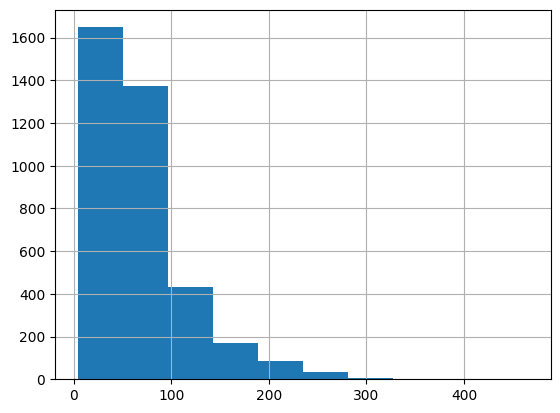

count    3750.000000
mean       68.969600
std        48.098582
min         4.000000
25%        39.000000
50%        54.000000
75%        84.000000
max       466.000000
dtype: float64

In [397]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

Observations : <br>a) Mean review length = around 69.<br> b) minimum length of reviews is 2.<br>c)There are quite a few reviews that are extremely long, we can manually investigate them to check whether we need to include or exclude them from our analysis.

### Padding

Now we will pad each of the sequence to max length

In [398]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [399]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,69) #padding_(x_train,500)
x_test_pad = padding_(x_test,69) #padding_(x_test,500)

### Batching and loading as tensor

In [400]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 1

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [401]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)


Sample input size:  torch.Size([1, 69])
Sample input: 
 tensor([[  2, 401,  48,  49,  57, 159,  14, 200,  54, 628, 162, 121, 261,  51,
          12, 200, 583,  21,  30,  13,  31,  87,  70,  63, 305, 259, 295,  23,
         675, 121, 395, 600, 343, 589,  47, 161,  72, 589, 395,  21, 237,  37,
          35,  87, 126, 582, 794, 794, 103,  58,  15,   6, 738,   1,   1, 297,
          35, 655, 235,   5, 702,  44, 991, 202,  30, 330, 863, 343, 305]])
Sample input: 
 tensor([0])


We need to add an embedding layer because there are less words in our vocabulary. It is massively inefficient to one-hot encode that many classes. So, instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table. You could train an embedding layer using Word2Vec, then load it here. But, it's fine to just make a new layer, using it for only dimensionality reduction, and let the network learn the weights.

### Models

In [414]:
class Cerebral_LSTMCell(nn.Module):
    def __init__(self,input_size,hidden_size,bias=True):
        super(Cerebral_LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.weight_fx_u = nn.Linear(input_size, hidden_size, bias=bias)
        self.weight_ix_u = nn.Linear(input_size, hidden_size, bias=bias)
        self.weight_cx_u = nn.Linear(input_size, hidden_size, bias=bias)
        self.weight_ox_u = nn.Linear(input_size, hidden_size, bias=bias)
        
        self.weight_fh_u = nn.Linear(hidden_size, hidden_size, bias=bias)
        self.weight_ih_u = nn.Linear(hidden_size, hidden_size, bias=bias)
        self.weight_ch_u = nn.Linear(hidden_size, hidden_size, bias=bias)
        self.weight_oh_u = nn.Linear(hidden_size, hidden_size, bias=bias)
    
        self.weight_fx_l = nn.Linear(input_size, hidden_size, bias=bias)
        self.weight_ix_l = nn.Linear(input_size, hidden_size, bias=bias)
        self.weight_cx_l = nn.Linear(input_size, hidden_size, bias=bias)
        self.weight_ox_l = nn.Linear(input_size, hidden_size, bias=bias)
        
        self.weight_fh_l = nn.Linear(hidden_size, hidden_size, bias=bias)
        self.weight_ih_l = nn.Linear(hidden_size, hidden_size, bias=bias)
        self.weight_ch_l = nn.Linear(hidden_size, hidden_size, bias=bias)
        self.weight_oh_l = nn.Linear(hidden_size, hidden_size, bias=bias)
        
    def forward(self,inp, h,uc,lc):
          u_f_g = torch.sigmoid(self.weight_fx_u(inp) + self.weight_fh_u(h))
          u_i_g = torch.sigmoid(self.weight_ix_u(inp) + self.weight_ih_u(h))
          u_o_g = torch.sigmoid(self.weight_ox_u(inp) + self.weight_oh_u(h))
          u_c_tilda = torch.tanh(self.weight_cx_u(inp) + self.weight_ch_u(h))
          u_c_t = u_f_g * uc + u_i_g * u_c_tilda
    
          l_f_g = torch.sigmoid(self.weight_fx_l(inp) + self.weight_fh_l(h))
          l_i_g = torch.sigmoid(self.weight_ix_l(inp) + self.weight_ih_l(h))
          l_o_g = torch.sigmoid(self.weight_ox_l(inp) + self.weight_oh_l(h))
          l_c_tilda = torch.tanh(self.weight_cx_l(inp) + self.weight_ch_l(h))
          l_c_t = l_f_g * lc + l_i_g * l_c_tilda
          
          h_t = (u_o_g * torch.tanh(u_c_t))+(l_o_g * torch.tanh(l_c_t))
        
          return h_t, u_c_t, l_c_t

In [416]:
class Cerebral_LSTM_RNN(nn.Module):
    def __init__(self,vocab_size,hidden_dim,output_dim, embedding_dim,drop_prob):
        super(Cerebral_LSTM_RNN,self).__init__()

        self.output_dim = output_dim #hidden_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #Cerebral lstm
        self.cerebral_lstm = Cerebral_LSTMCell(input_size=embedding_dim,hidden_size=self.hidden_dim)

        # dropout layer
        self.dropout = nn.Dropout(drop_prob)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,h,uc,cell_state_lower):
        # embeddings and lstm_out
        embeds = self.embedding(x)
        hidden, cell_state_upper, cell_state_lower = self.cerebral_lstm(embeds, h, uc, cell_state_lower)
        # dropout and fully connected layer
        out = self.dropout(hidden)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        # return last sigmoid output and hidden state
        return sig_out, hidden, cell_state_upper, cell_state_lower

    def init_hidden(self, batch_size=1):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        hidden_state_0 = torch.zeros((batch_size,self.hidden_dim)).to(device)
        cell_state_upper_0 = torch.zeros((batch_size, self.hidden_dim)).to(device)
        cell_state_lower_0 = torch.zeros((batch_size,self.hidden_dim)).to(device)
        return  (hidden_state_0, cell_state_upper_0, cell_state_lower_0)


In [417]:
class LSTMCell(nn.Module):
  def __init__(self,input_size,hidden_size,bias=True):
    super(LSTMCell, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    
    self.weight_fx = nn.Linear(input_size, hidden_size, bias=bias)
    self.weight_ix = nn.Linear(input_size, hidden_size, bias=bias)
    self.weight_cx = nn.Linear(input_size, hidden_size, bias=bias)
    self.weight_ox = nn.Linear(input_size, hidden_size, bias=bias)
    
    self.weight_fh = nn.Linear(hidden_size, hidden_size, bias=bias)
    self.weight_ih = nn.Linear(hidden_size, hidden_size, bias=bias)
    self.weight_ch = nn.Linear(hidden_size, hidden_size, bias=bias)
    self.weight_oh = nn.Linear(hidden_size, hidden_size, bias=bias)
    
    
  def forward(self,inp, h,c):
      f_g = torch.sigmoid(self.weight_fx(inp) + self.weight_fh(h))
      i_g = torch.sigmoid(self.weight_ix(inp) + self.weight_ih(h))
      o_g = torch.sigmoid(self.weight_ox(inp) + self.weight_oh(h))
      c_tilda = torch.tanh(self.weight_cx(inp) + self.weight_ch(h))
      c_t = f_g * c + i_g * c_tilda
      h_t = o_g * torch.tanh(c_t)
    
      return h_t, c_t

In [418]:
class LSTM_RNN(nn.Module):
    def __init__(self,vocab_size,hidden_dim,output_dim,embedding_dim,drop_prob):
        super(LSTM_RNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm
        self.lstm = LSTMCell(input_size=embedding_dim,hidden_size=self.hidden_dim)

        # dropout layer
        self.dropout = nn.Dropout(drop_prob)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,h,uc):
        # embeddings and lstm_out
        embeds = self.embedding(x)
        hidden, cell_state_upper = self.lstm(embeds, h, uc)
        # dropout and fully connected layer
        out = self.dropout(hidden)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        # return last sigmoid output and hidden state
        return sig_out, hidden, cell_state_upper,



    def init_hidden(self, batch_size=1):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        hidden_state_0 = torch.zeros((batch_size,self.hidden_dim)).to(device)
        cell_state_0 = torch.zeros((batch_size, self.hidden_dim)).to(device)
        return  (hidden_state_0, cell_state_0)

### Parameters used for Cerebral LSTM

In [424]:
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 10 # Try with other values of Embedding Size
output_dim = 1
hidden_dim = 16 # Try with other values of Hidden Dimension Size

# "CerabralLSTM":
Cerebral_LSTM_model = Cerebral_LSTM_RNN(vocab_size,hidden_dim,output_dim,embedding_dim,drop_prob=0.3)

#moving to gpu
Cerebral_LSTM_model.to(device)

Cerebral_LSTM_RNN(
  (embedding): Embedding(1001, 10)
  (cerebral_lstm): Cerebral_LSTMCell(
    (weight_fx_u): Linear(in_features=10, out_features=16, bias=True)
    (weight_ix_u): Linear(in_features=10, out_features=16, bias=True)
    (weight_cx_u): Linear(in_features=10, out_features=16, bias=True)
    (weight_ox_u): Linear(in_features=10, out_features=16, bias=True)
    (weight_fh_u): Linear(in_features=16, out_features=16, bias=True)
    (weight_ih_u): Linear(in_features=16, out_features=16, bias=True)
    (weight_ch_u): Linear(in_features=16, out_features=16, bias=True)
    (weight_oh_u): Linear(in_features=16, out_features=16, bias=True)
    (weight_fx_l): Linear(in_features=10, out_features=16, bias=True)
    (weight_ix_l): Linear(in_features=10, out_features=16, bias=True)
    (weight_cx_l): Linear(in_features=10, out_features=16, bias=True)
    (weight_ox_l): Linear(in_features=10, out_features=16, bias=True)
    (weight_fh_l): Linear(in_features=16, out_features=16, bias=True

#### Loss function and optimizer for Cerebral LSTM

In [425]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer_Cerebral_LSTM = torch.optim.Adam(Cerebral_LSTM_model.parameters(), lr=lr)
schedular_Cerebral_LSTM = StepLR(optimizer_Cerebral_LSTM, step_size=4, gamma=0.1)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

#### Training and Validation using Cerebral LSTM

In [426]:
if Select_Model in ["Cerebral_LSTM", "ALL", "BOTH"]:
  clip = 5
  epochs = 10
  valid_loss_min = np.Inf
  # train for some number of epochs
  epoch_tr_loss,epoch_vl_loss = [],[]
  epoch_tr_acc,epoch_vl_acc = [],[]
  # TRAIN AND VALIDATE Cerebral LSTM
  for epoch in range(epochs):
        
        train_losses = []
        train_acc = 0.0
        Cerebral_LSTM_model.train()
        # initialize hidden state
        
        with tqdm(train_loader, unit=" Train batch") as tepoch:
          tepoch.set_description(f"Epoch {epoch+1}")
          for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)
            output = None
            for single_sentence in inputs:
              Cerebral_LSTM_model.zero_grad()
              h,uc,lc = Cerebral_LSTM_model.init_hidden(batch_size=1)
              for each_elem in single_sentence:
                word = each_elem.unsqueeze(dim=0)
                output, h, uc, lc = Cerebral_LSTM_model(word,h,uc,lc)
            loss = criterion(input=output.squeeze(dim=0), target=labels.float())
            train_losses.append(loss.item())
            loss.backward()
            
            # calculating accuracy
            accuracy = acc(output,labels)
            train_acc += accuracy
            #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(Cerebral_LSTM_model.parameters(), clip)
            optimizer_Cerebral_LSTM.step()
            

        # validation code
        val_losses = []
        val_acc = 0.0
        Cerebral_LSTM_model.eval()
        with tqdm(valid_loader, unit=" Valid batch") as vepoch:
          vepoch.set_description(f"Epoch {epoch+1}")
          for inputs, labels in vepoch:
            inputs, labels = inputs.to(device), labels.to(device)
            output = None
            for single_sentence in inputs:
                val_h, val_uc, val_lc = Cerebral_LSTM_model.init_hidden(batch_size=1)
                for each_elem in single_sentence:
                  word = each_elem.unsqueeze(dim=0)
                  with torch.no_grad():
                    output, val_h, val_uc, val_lc = Cerebral_LSTM_model(word,val_h,val_uc,val_lc)
            val_loss = criterion(output.squeeze(dim=0), labels.float())
            val_losses.append(val_loss.item())
            accuracy = acc(output.squeeze(dim=0),labels)
            val_acc += accuracy

        # matrices log
        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_acc = train_acc/len(train_loader.dataset)
        epoch_val_acc = val_acc/len(valid_loader.dataset)
        epoch_tr_loss.append(epoch_train_loss)
        epoch_vl_loss.append(epoch_val_loss)
        epoch_tr_acc.append(epoch_train_acc)
        epoch_vl_acc.append(epoch_val_acc)
        print(f'Epoch {epoch+1}')
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
        if epoch_val_loss <= valid_loss_min:
            torch.save(Cerebral_LSTM_model.state_dict(), root_path+"Cerebral_LSTM/cerebral_lstm_dict_"+str(epoch+1)+".pt")
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
            valid_loss_min = epoch_val_loss
        print(25*'==')
        schedular_Cerebral_LSTM.step()

Epoch 1: 100%|████████████████████| 1250/1250 [01:09<00:00, 18.08 Valid batch/s]


Epoch 1
train_loss : 0.6751044564406077 val_loss : 0.6446076736569405
train_accuracy : 56.82666666666667 val_accuracy : 61.919999999999995
Validation loss decreased (inf --> 0.644608).  Saving model ...


Epoch 2: 100%|████████████████████| 1250/1250 [00:13<00:00, 94.55 Valid batch/s]


Epoch 2
train_loss : 0.5891946601534883 val_loss : 0.5945513446688652
train_accuracy : 69.89333333333333 val_accuracy : 68.64
Validation loss decreased (0.644608 --> 0.594551).  Saving model ...


Epoch 3: 100%|████████████████████| 1250/1250 [00:13<00:00, 93.53 Valid batch/s]


Epoch 3
train_loss : 0.5020565814778208 val_loss : 0.5190069159001112
train_accuracy : 76.98666666666666 val_accuracy : 75.68
Validation loss decreased (0.594551 --> 0.519007).  Saving model ...


Epoch 4: 100%|████████████████████| 1250/1250 [00:13<00:00, 95.84 Valid batch/s]


Epoch 4
train_loss : 0.4372967015707244 val_loss : 0.5340042226091027
train_accuracy : 82.56 val_accuracy : 76.88000000000001


Epoch 5: 100%|████████████████████| 1250/1250 [00:13<00:00, 96.14 Valid batch/s]


Epoch 5
train_loss : 0.3608129015063246 val_loss : 0.5176792229250073
train_accuracy : 86.16 val_accuracy : 77.68
Validation loss decreased (0.519007 --> 0.517679).  Saving model ...


Epoch 6: 100%|████████████████████| 1250/1250 [00:13<00:00, 94.54 Valid batch/s]


Epoch 6
train_loss : 0.3530396976939092 val_loss : 0.5214862819626928
train_accuracy : 86.56 val_accuracy : 78.4


Epoch 7: 100%|████████████████████| 1250/1250 [00:13<00:00, 95.23 Valid batch/s]


Epoch 7
train_loss : 0.34562263982060054 val_loss : 0.5363245229519904
train_accuracy : 87.2 val_accuracy : 78.48


Epoch 8: 100%|████████████████████| 1250/1250 [00:13<00:00, 95.79 Valid batch/s]


Epoch 8
train_loss : 0.34423090760701647 val_loss : 0.5360688980206847
train_accuracy : 87.17333333333333 val_accuracy : 78.48


Epoch 9: 100%|████████████████████| 1250/1250 [00:13<00:00, 95.15 Valid batch/s]


Epoch 9
train_loss : 0.32762143566502877 val_loss : 0.5404458789266646
train_accuracy : 87.78666666666666 val_accuracy : 78.64


Epoch 10: 100%|███████████████████| 1250/1250 [00:13<00:00, 96.12 Valid batch/s]

Epoch 10
train_loss : 0.3264931403083727 val_loss : 0.5429904807753861
train_accuracy : 87.76 val_accuracy : 78.4


#### Analysis of Training and Validation Loss and Accuracy for Cerebral LSTM

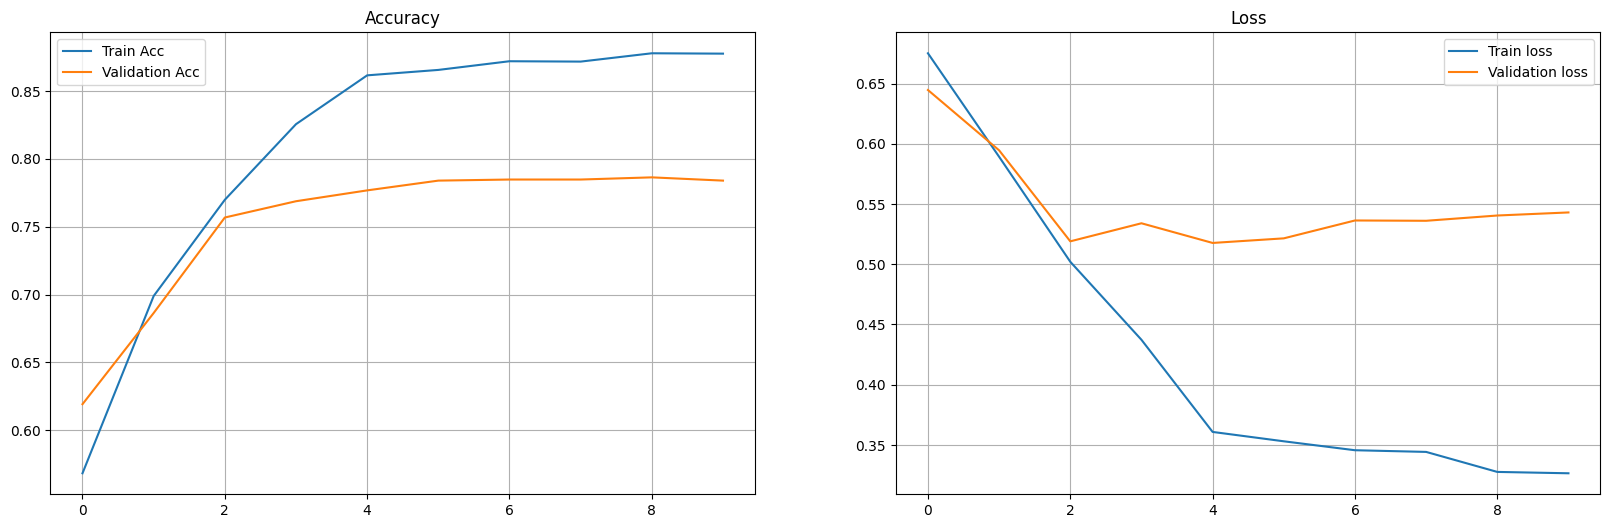

<Figure size 640x480 with 0 Axes>

In [427]:
if Select_Model in ["Cerebral_LSTM", "ALL", "BOTH"]:
    fig = plt.figure(figsize = (20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_tr_acc, label='Train Acc')
    plt.plot(epoch_vl_acc, label='Validation Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(epoch_tr_loss, label='Train loss')
    plt.plot(epoch_vl_loss, label='Validation loss')
    plt.title("Loss")
    plt.legend()
    plt.grid()
    plt.show()
    plt.savefig('Cerebral_LSTM_OVERALL.pdf')

### Parameters used for Simple LSTM

In [434]:
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 10 # Try with other values of Embedding Size
output_dim = 1
hidden_dim = 16 # Try with other values of Hidden Dimension Size

# "LSTM":
LSTM_model = LSTM_RNN(vocab_size, hidden_dim, output_dim, embedding_dim, drop_prob=0.3)

#moving to gpu
LSTM_model.to(device)

LSTM_RNN(
  (embedding): Embedding(1001, 10)
  (lstm): LSTMCell(
    (weight_fx): Linear(in_features=10, out_features=16, bias=True)
    (weight_ix): Linear(in_features=10, out_features=16, bias=True)
    (weight_cx): Linear(in_features=10, out_features=16, bias=True)
    (weight_ox): Linear(in_features=10, out_features=16, bias=True)
    (weight_fh): Linear(in_features=16, out_features=16, bias=True)
    (weight_ih): Linear(in_features=16, out_features=16, bias=True)
    (weight_ch): Linear(in_features=16, out_features=16, bias=True)
    (weight_oh): Linear(in_features=16, out_features=16, bias=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=16, out_features=1, bias=True)
  (sig): Sigmoid()
)

#### Loss function and optimizer for Simple LSTM

In [435]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer_LSTM = torch.optim.Adam(LSTM_model.parameters(), lr=lr)
schedular_LSTM = StepLR(optimizer_LSTM, step_size=4, gamma=0.1)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

### Training and Validation using Simple LSTM 

In [436]:
if Select_Model in ["LSTM", "ALL", "BOTH"]:
  # TRAIN AND VALIDATE LSTM
  clip = 5
  epochs = 10
  valid_loss_min = np.Inf
  # train for some number of epochs
  epoch_tr_loss,epoch_vl_loss = [],[]
  epoch_tr_acc,epoch_vl_acc = [],[]
  for epoch in range(epochs):
      train_losses = []
      train_acc = 0.0
      LSTM_model.train()
      # initialize hidden state
      with tqdm(train_loader, unit=" Train batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}")
        for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)
            output = None
            for single_sentence in inputs:
              LSTM_model.zero_grad()
              h, uc = LSTM_model.init_hidden(batch_size=1)
              for each_elem in single_sentence:
                word = each_elem.unsqueeze(dim=0)
                output, h, uc  = LSTM_model(word,h,uc)

            loss = criterion(input=output.squeeze(dim=0), target=labels.float())
            train_losses.append(loss.item())
            loss.backward()
            
            # calculating accuracy
            accuracy = acc(output,labels)
            train_acc += accuracy
            #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(LSTM_model.parameters(), clip)
            optimizer_LSTM.step()

        # validation code
        val_losses = []
        val_acc = 0.0
        LSTM_model.eval()
        with tqdm(valid_loader, unit=" Valid batch") as vepoch:
          vepoch.set_description(f"Epoch {epoch+1}")
          for inputs, labels in vepoch:
            inputs, labels = inputs.to(device), labels.to(device)
            output = None
            for single_sentence in inputs:
                val_h, val_uc = LSTM_model.init_hidden(batch_size=1)
                for each_elem in single_sentence:
                  word = each_elem.unsqueeze(dim=0)
                  with torch.no_grad():
                    output, val_h, val_uc = LSTM_model(word, val_h, val_uc)
            val_loss = criterion(output.squeeze(dim=0), labels.float())
            val_losses.append(val_loss.item())
            accuracy = acc(output.squeeze(dim=0),labels)
            val_acc += accuracy

        # matrices log
        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_acc = train_acc/len(train_loader.dataset)
        epoch_val_acc = val_acc/len(valid_loader.dataset)
        epoch_tr_loss.append(epoch_train_loss)
        epoch_vl_loss.append(epoch_val_loss)
        epoch_tr_acc.append(epoch_train_acc)
        epoch_vl_acc.append(epoch_val_acc)
        print(f'Epoch {epoch+1}')
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
        if epoch_val_loss <= valid_loss_min:
            torch.save(LSTM_model.state_dict(), root_path+"Cerebral_LSTM/lstm_state_dict_"+str(epoch+1)+".pt")
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
            valid_loss_min = epoch_val_loss
        print(25*'==')
        schedular_LSTM.step()

Epoch 1: 100%|███████████████████| 1250/1250 [00:07<00:00, 161.51 Valid batch/s]


Epoch 1
train_loss : 0.6904654484272004 val_loss : 0.684345504784584
train_accuracy : 53.65333333333333 val_accuracy : 55.76
Validation loss decreased (inf --> 0.684346).  Saving model ...


Epoch 2: 100%|███████████████████| 1250/1250 [00:07<00:00, 165.25 Valid batch/s]


Epoch 2
train_loss : 0.6412673257748286 val_loss : 0.6023843701124191
train_accuracy : 64.42666666666666 val_accuracy : 68.56
Validation loss decreased (0.684346 --> 0.602384).  Saving model ...


Epoch 3: 100%|███████████████████| 1250/1250 [00:07<00:00, 164.76 Valid batch/s]


Epoch 3
train_loss : 0.5320974762966235 val_loss : 0.5754918409138918
train_accuracy : 74.8 val_accuracy : 73.2
Validation loss decreased (0.602384 --> 0.575492).  Saving model ...


Epoch 4: 100%|███████████████████| 1250/1250 [00:07<00:00, 161.29 Valid batch/s]


Epoch 4
train_loss : 0.4637503988491992 val_loss : 0.5127470727175474
train_accuracy : 80.34666666666666 val_accuracy : 75.92
Validation loss decreased (0.575492 --> 0.512747).  Saving model ...


Epoch 5: 100%|███████████████████| 1250/1250 [00:07<00:00, 165.06 Valid batch/s]


Epoch 5
train_loss : 0.3950425031167765 val_loss : 0.5210150769263506
train_accuracy : 84.18666666666667 val_accuracy : 76.8


Epoch 6: 100%|███████████████████| 1250/1250 [00:07<00:00, 163.91 Valid batch/s]


Epoch 6
train_loss : 0.3910173014141619 val_loss : 0.5214043544992805
train_accuracy : 84.69333333333333 val_accuracy : 77.44


Epoch 7: 100%|███████████████████| 1250/1250 [00:07<00:00, 163.62 Valid batch/s]


Epoch 7
train_loss : 0.3792318211566657 val_loss : 0.5293340206220746
train_accuracy : 85.11999999999999 val_accuracy : 77.68


Epoch 8: 100%|███████████████████| 1250/1250 [00:07<00:00, 163.12 Valid batch/s]


Epoch 8
train_loss : 0.3704944159451872 val_loss : 0.529388684593141
train_accuracy : 86.08 val_accuracy : 77.84


Epoch 9: 100%|███████████████████| 1250/1250 [00:07<00:00, 164.53 Valid batch/s]


Epoch 9
train_loss : 0.36280301577722035 val_loss : 0.5300308787852526
train_accuracy : 86.29333333333334 val_accuracy : 77.84


Epoch 10: 100%|██████████████████| 1250/1250 [00:07<00:00, 163.20 Valid batch/s]

Epoch 10
train_loss : 0.36397946534579 val_loss : 0.5321526993960142
train_accuracy : 86.37333333333333 val_accuracy : 78.0


#### Analysis of Training and Validation Loss and Accuracy for Simple LSTM

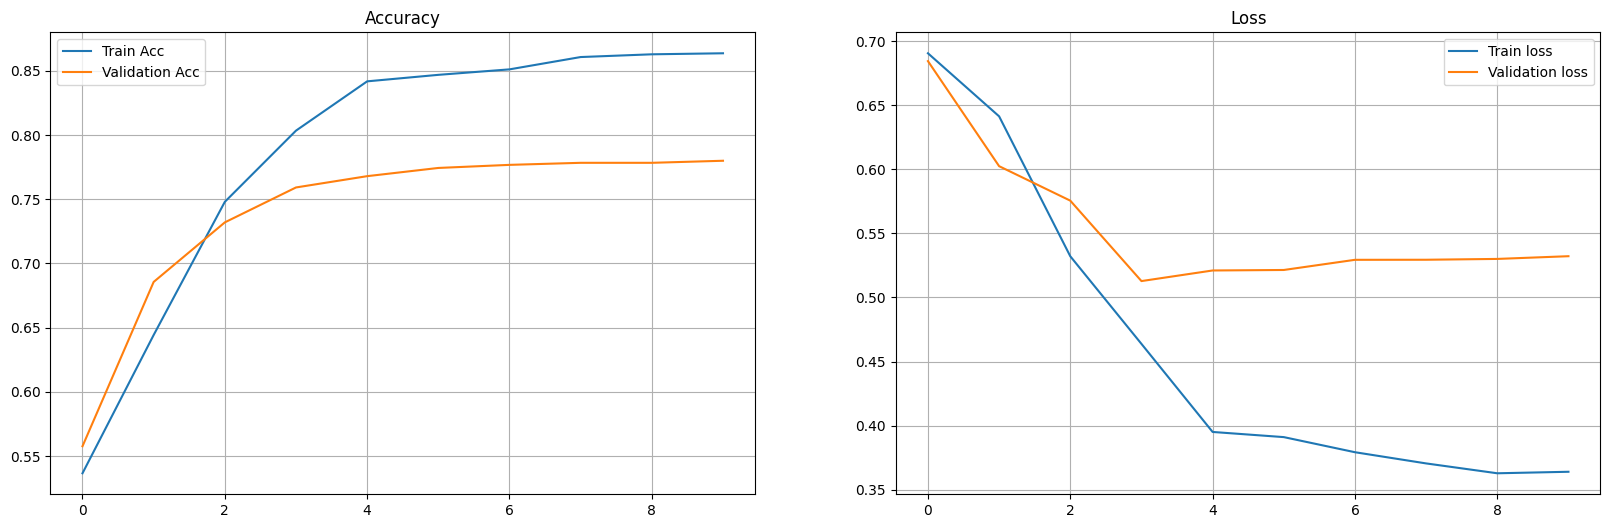

<Figure size 640x480 with 0 Axes>

In [437]:
if Select_Model in ["LSTM", "ALL", "BOTH"]:
    fig = plt.figure(figsize = (20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_tr_acc, label='Train Acc')
    plt.plot(epoch_vl_acc, label='Validation Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(epoch_tr_loss, label='Train loss')
    plt.plot(epoch_vl_loss, label='Validation loss')
    plt.title("Loss")
    plt.legend()
    plt.grid()
    
    plt.show()
    plt.savefig('LSTM_OVERALL.pdf')

#### Observations when using Cerebral LSTM vs Simple LSTM:

With the same configurations and training parameters, even on a smaller dataset. (Cerebral LSTM works better with larger dataset): 
```python
lr=0.001
epochs = 10
criterion = nn.BCELoss()

optimizer= torch.optim.Adam(model.parameters(), lr=lr)
schedular = StepLR(optimizer, step_size=2, gamma=0.1)
```
- Cerebral LSTM have highest `validation set accuracy` of `78.64`. While, Simple LSTM provided highest `validation set accuracy` of `78.0`.
- Cerebral LSTM have highest `training set accuracy` of `87.786`. While, Simple LSTM provided highest `training set accuracy` of `86.373`.